In [2]:
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
from sklearn.metrics import classification_report
import pathlib
import random
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc, melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from research.dataImporting import MLtools
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D, Conv2D, SeparableConv1D, MaxPooling1D,MaxPooling2D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation, LSTM, Lambda, Reshape, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from research.dataImporting import dataTools
import keras.backend as K

In [3]:
training_df_raw=pd.read_csv("0.5s_raw_range_A1_A2_A3_no_overlap.csv")

In [14]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
bad_runs=["A3R6P1","A3R4P4","A3R4P5","A3R3P4","A3R3P5"]
good_runs_IF=["A1R1P1","A1R1P2","A1R1P3","A1R1P4","A1R1P5","A2R1P1","A2R1P2","A2R1P3","A2R1P4","A2R1P5","A2R2P1","A2R2P2","A2R2P3","A2R2P4","A2R2P5"]
good_runs_matrice=["A1R2P2","A1R2P3","A1R2P4","A1R2P5","A2R3P1","A2R3P2","A2R4P1","A2R4P2","A2R4P3","A3R3P1","A3R3P2","A3R4P2","A3R4P3","A3R4P5"]
good_runs_phantom=["A2R5P1","A2R5P2","A2R5P3","A2R5P4","A2R5P5","A2R6P1","A2R6P2","A2R6P3","A2R6P4","A2R6P5","A3R5P1","A3R5P2","A3R5P3","A3R5P4","A3R6P1","A3R6P2","A3R6P3","A3R6P4"]
test_runs_matrice=["A2R3P3","A3R3P3"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
x_data=[]
y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges

def classFinder(distance):
    if distance<=40 :
        class_val=0
    elif distance<=60:
        class_val=1
    elif distance<=80:
        class_val=2
    else:
        class_val=3
    return class_val

def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    pass_df=training_df_raw.loc[training_df_raw[str(notable_col_names.index('Pass'))] == full_name]
    #pass_df=training_df.loc[training_df["Pass"] == full_name]
    max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    #max_segment=pass_df["Segment"].max()
    #for i in range(0,max_segment):
    print(full_name)
    #if full_name in good_runs_matrice or full_name in good_runs_phantom or full_name in good_runs_IF:
    if full_name in good_runs_matrice:
        for phone in phone_slots:
            phone_seg=pass_df.loc[pass_df[str(notable_col_names.index('Phone'))]==phone]
        # frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        #frame_df=pass_df.loc[pass_df["Segment"]==i]
            twd_frame=[]
            range_frame=[]
        #for phone in phone_slots:
            for i in range(0,max_segment):
                frame_df=phone_seg.loc[phone_seg[str(notable_col_names.index('Segment'))]==i]
            # phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            #phone_seg=frame_df.loc[frame_df["Name"]==phone]
                data=np.array(frame_df.iloc[:,8:4008])
            #data=np.array(frame_df.iloc[:,-512:])
            # dist=phone_seg[str(notable_col_names.index('Range'))]
                dist=frame_df[str(notable_col_names.index('Range'))]
            #dist=phone_seg["Range"]
                if len(np.array(dist)>0):
                    if np.array(dist)[0]<250:
                        data=data[0]
                        #data=np.reshape(data,(64,4))
                        #data=np.reshape(data,(40,1))
                        dist=np.array(dist)[0]
                        class_value=classFinder(dist)
                        twd_frame.append(data)
                        range_frame.append(dist)
            #y_vals= rangeClosest(range_frame)
            x_data.extend(np.array(twd_frame))
            y_data.extend(np.array(range_frame))

A1R1P1
A1R1P2
A1R1P3
A1R1P4
A1R1P5
A1R2P1
A1R2P2
A1R2P3
A1R2P4
A1R2P5
A2R1P1
A2R1P2
A2R1P3
A2R1P4
A2R1P5
A2R2P1
A2R2P2
A2R2P3
A2R2P4
A2R2P5
A2R3P1
A2R3P2
A2R3P3
A2R4P1
A2R4P2
A2R4P3
A2R5P1
A2R5P2
A2R5P3
A2R5P4
A2R5P5
A2R6P1
A2R6P2
A2R6P3
A2R6P4
A2R6P5
A2R7P1
A2R7P2
A2R7P3
A2R7P4
A2R7P5
A2R8P1
A2R8P2
A2R8P3
A2R8P4
A2R8P5
A3R3P1
A3R3P2
A3R3P3
A3R3P4
A3R3P5
A3R4P1
A3R4P2
A3R4P3
A3R4P4
A3R4P5
A3R5P1
A3R5P2
A3R5P3
A3R5P4
A3R6P1
A3R6P2
A3R6P3
A3R6P4


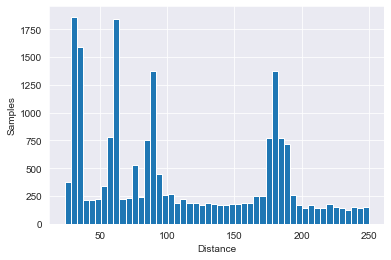

In [18]:
def subsample(x_data,y_data):
    new_x=[]
    new_y=[]
    rng=np.random.default_rng(12345)
    for x in range(len(x_data)):
        rand_vals=rng.integers(low=1,high=5,size=1)
        if y_data[x]==3 and rand_vals[0]==2:
        #if y_data[x][0]==3 and rand_vals[0]==2:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
        elif y_data[x] != 3:
            new_x.append(x_data[x])
            new_y.append(y_data[x])
    return np.array(new_x), np.array(new_y)
x_data=np.array(x_data)
x_data=np.float32(x_data)
#x_data=np.transpose(x_data,axes=[0,2,1])
y_data=np.array(y_data)
x__,y__=subsample(x_data,y_data)
train_feats,test_feats,train_targs,test_targs=train_test_split(x__,y__,test_size=0.2,shuffle=True,random_state=42)
# range_train_targs_oh=tf.keras.utils.to_categorical(train_targs,num_classes=4)
# range_test_targs_oh=tf.keras.utils.to_categorical(test_targs,num_classes=4)
# class_train_targs=train_targs[:,1]
# cont_range_train_targs=train_targs[:,2]
# range_train_targs=train_targs[:,0]
# class_train_targs_oh=tf.keras.utils.to_categorical(class_train_targs,num_classes=3)
# range_train_targs_oh=tf.keras.utils.to_categorical(range_train_targs,num_classes=4)
# class_test_targs=test_targs[:,1]
# cont_range_test_targs=test_targs[:,2]
# range_test_targs=test_targs[:,0]
# class_test_targs_oh=tf.keras.utils.to_categorical(class_test_targs,num_classes=3)
# range_test_targs_oh=tf.keras.utils.to_categorical(range_test_targs,num_classes=4)
plt.hist(y__,bins=50)
plt.xlabel("Distance")
plt.ylabel("Samples")
plt.savefig("DS2Distro_cont.pdf")

In [19]:
len(x__)/2

10170.0